In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

# isn't there anything similar from tensorflow? split_dataset (tensorflow.keras.utils) only divides in left and right
# There is but the data-type outcome is shitty, its PrefetchData, and it's annoying to work with it, I am open if you get it to work properly
# Included the orders in the loading section, test it for yourself :)

from sklearn.model_selection import train_test_split

# Direct classes included for easyness
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model

In [2]:
# Load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split)
# seed = np.random.seed(156703)
# x_train, x_test = tf.keras.utils.split_dataset(input, right_size=test_split, shuffle = True, seed=seed)
# y_train, y_test = tf.keras.utils.split_dataset(noise_output, right_size=test_split, shuffle = True, seed=seed)

### Enter your tag as unique id for saving

In [3]:
tag = str("sQNN3-17032023")

Params in the quantum layer to train: 1
0: ──H──RX(0.05)─╭●──────────╭X──Rot(0.95,0.52,0.04)─╭●──H───────┤  <Z>
1: ──H──RX(0.57)─╰X─╭●───────│───Rot(0.69,0.75,0.31)─├●─╭●──H────┤  <Z>
2: ──H──RX(0.00)────╰X─╭●────│───Rot(0.55,0.73,0.99)─╰X─├●─╭●──H─┤  <Z>
3: ──H──RX(0.20)───────╰X─╭●─│───Rot(0.59,0.85,0.31)────╰X─├●──H─┤  <Z>
4: ──H──RX(0.22)──────────╰X─╰●──Rot(0.50,0.94,0.34)───────╰X──H─┤  <Z>


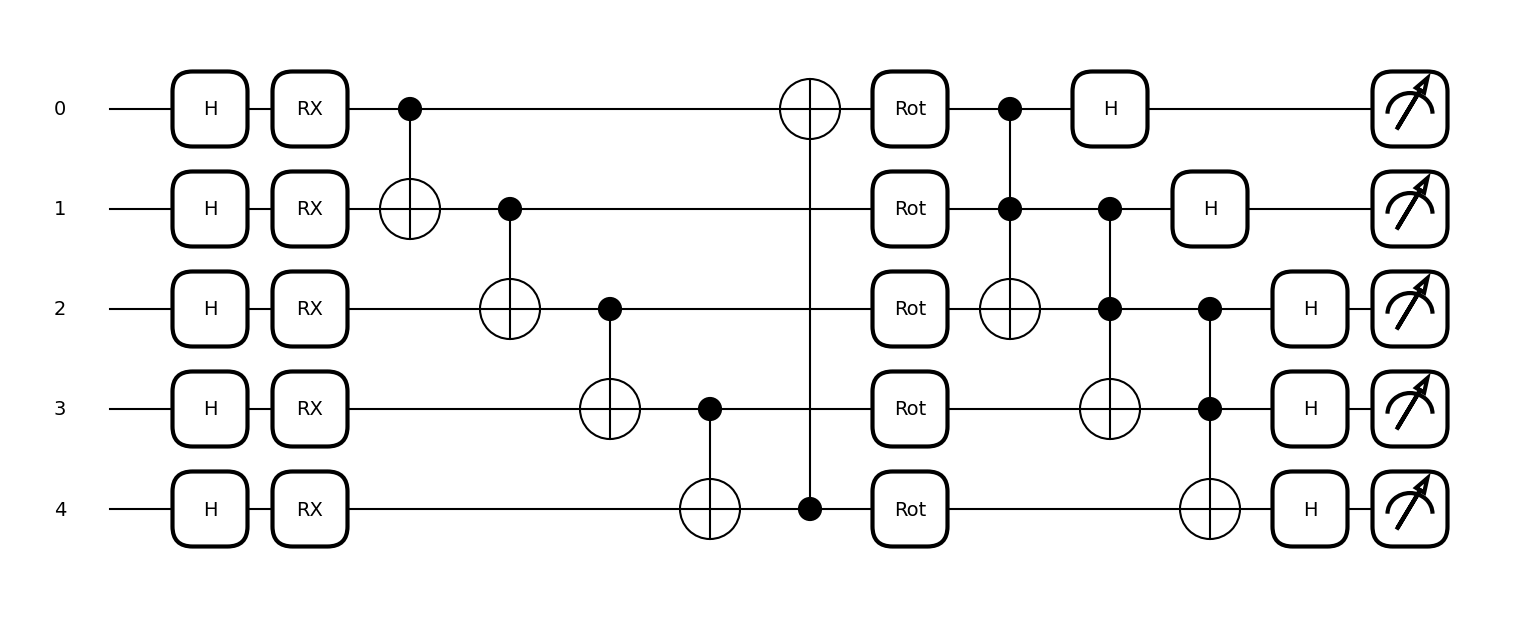

<Figure size 640x480 with 0 Axes>

In [7]:
from pennylane import numpy as np
n_qubits = x_train.shape[1]
params = 3
weight_shapes = {"weight1": (n_qubits,params)}
                #  "weight2": (n_qubits),
                #  "weight3": (n_qubits)}
n_qcParams = len(weight_shapes)
print(f"Params in the quantum layer to train: {n_qcParams}")

dev = qml.device("default.qubit", wires=n_qubits)  # number of shots default? =1 du Horst

@qml.qnode(dev)
def qnode(inputs, weight1):#, weight2, weight3):
    qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
    qml.broadcast(qml.RX, wires=range(n_qubits), parameters=inputs, pattern="single")
    qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="ring")
    qml.broadcast(qml.Rot, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.Toffoli(wires=[0,1,2])
    qml.Toffoli(wires=[1,2,3])
    qml.Toffoli(wires=[2,3,4])
    # qml.broadcast(qml.CRY, wires=range(n_qubits), parameters= weight2, pattern="ring")
    # qml.broadcast(qml.CRZ, wires=range(n_qubits), parameters= weight3,  pattern="ring")
    qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(qnode)(x_train[0,:],np.random.rand(n_qubits,3)))#, np.random.rand(n_qubits), np.random.rand(n_qubits)))
fig, ax = qml.draw_mpl(qnode)(x_train[0,:],np.random.rand(n_qubits,3, requires_grad=True))#, np.random.rand(n_qubits), np.random.rand(n_qubits))
plt.show()
plt.savefig("archive/Qnode-"+tag+".png")

In [8]:
#Create a simple ANN
import numpy as np
clear_session()
tf.keras.backend.set_floatx('float64')
layer_0 = Input(shape=(x_train.shape[1],))
layer_1 = Dense(5, activation="relu")
layer_2 = Dense(5, activation="linear")
ann = Sequential([layer_0, layer_1, qlayer, layer_2])
print(f"Params in the quantum layer to train: {n_qcParams}")
ann.summary()
plot_model(ann)

Params in the quantum layer to train: 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 keras_layer_1 (KerasLayer)  (None, 5)                 0 (unused)
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
#Training
def scheduler(epoch, lr):
    if epoch < 6:
        return lr
    else:
        return lr/8 #* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=5, patience=3)
opt = tf.keras.optimizers.RMSprop(learning_rate=0.18)

ann.compile(opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

ann_history = ann.fit(x_train, y_train, epochs=20, batch_size=25, validation_split=0.25, callbacks=[LearningRateScheduler, EarlyStopping])

Epoch 1/20
31/31 [==============================] - 88s 3s/step - loss: 10601.6652 - mean_absolute_error: 102.1102 - val_loss: 6916.6092 - val_mean_absolute_error: 82.8220 - lr: 0.1800
Epoch 2/20
31/31 [==============================] - 89s 3s/step - loss: 4914.3983 - mean_absolute_error: 69.3020 - val_loss: 2871.1396 - val_mean_absolute_error: 53.0476 - lr: 0.1800
Epoch 3/20
31/31 [==============================] - 90s 3s/step - loss: 1758.6801 - mean_absolute_error: 40.5989 - val_loss: 668.8925 - val_mean_absolute_error: 24.7361 - lr: 0.1800
Epoch 4/20
31/31 [==============================] - 91s 3s/step - loss: 316.5098 - mean_absolute_error: 15.5933 - val_loss: 68.9092 - val_mean_absolute_error: 7.0591 - lr: 0.1800
Epoch 5/20
31/31 [==============================] - 92s 3s/step - loss: 48.4136 - mean_absolute_error: 5.7369 - val_loss: 58.9579 - val_mean_absolute_error: 6.3341 - lr: 0.1800
Epoch 6/20
31/31 [==============================] - 91s 3s/step - loss: 108.9247 - mean_absolu

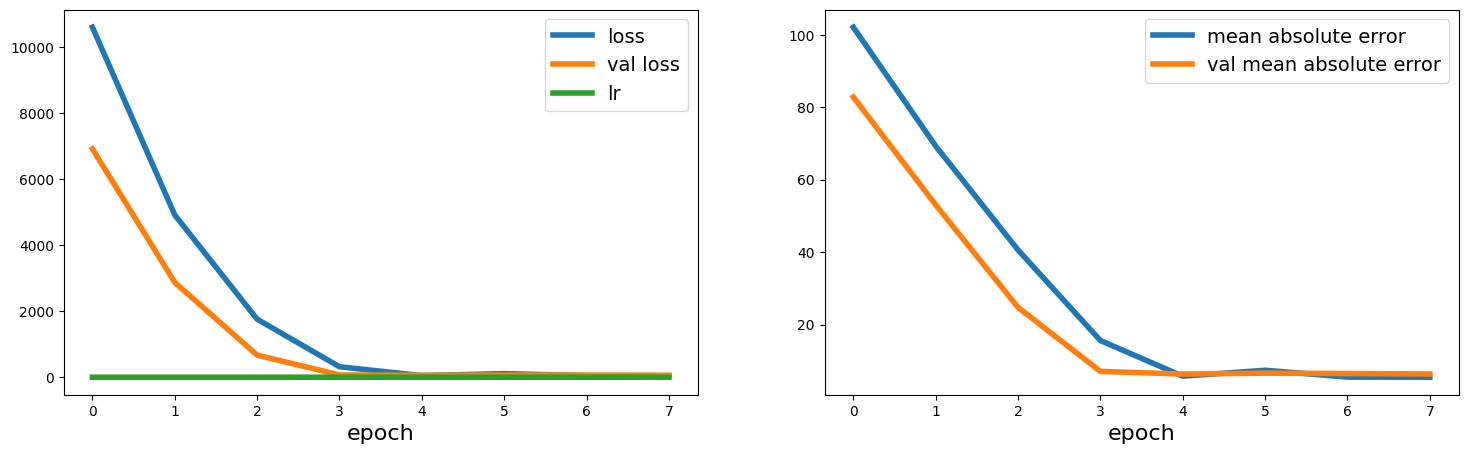

In [10]:
import numpy as np

def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(ann_history)
plt.savefig("archive/history-"+tag+".png")

In [11]:
evaluation = ann.evaluate(x_test[:-1], y_test[:-1])
ann.summary()

16/16 [==============================] - 22s 1s/step - loss: 46.9823 - mean_absolute_error: 5.4307
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 keras_layer_1 (KerasLayer)  (None, 5)                 15        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ann.save("archive/model-"+tag+".h5")
config = ann.get_config()
np.save("archive/config-"+tag+".npy", config)